# **Nama  : Wilson Boyaron Hutagalung**
# **NIM   : 2209106035**

#### Link Dataset: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

## Import Library
<p>Pada bagian ini, berbagai library Python diimpor untuk keperluan analisis data, visualisasi, pemodelan machine learning, dan penanganan data imbalance. Library seperti pandas dan numpy digunakan untuk manipulasi data, sklearn untuk preprocessing dan modeling, imblearn untuk penyeimbangan data, dan matplotlib untuk visualisasi.<p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from scipy import stats
import random

## Load Dataset
<p>Dataset Airlines.csv berisi data penerbangan dengan fitur seperti maskapai, bandara asal, bandara tujuan, waktu keberangkatan,
dan durasi penerbangan, serta kolom target 'Delay' (0: No Delay, 1: Delay). Dataset ini digunakan untuk memprediksi penundaan
penerbangan. Struktur dan isi dataset diperiksa untuk memahami jenis data, jumlah fitur, serta memeriksa nilai kosong atau duplikat.<p>

In [2]:
df = pd.read_csv("Airlines.csv")
print('='*20)
df.info()
print('='*20)
df.isna().sum()
print('='*20)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


## Clean Dataset
<p>Proses pembersihan data mencakup penghapusan duplikat, pengisian nilai kosong dengan rata-rata (khusus kolom numerik), serta menghapus outlier menggunakan Z-Score. Menghapus duplikat mencegah bias model akibat data berulang, mengisi nilai kosong memastikan algoritma berjalan tanpa error, dan menghapus outlier menjaga pola data agar tidak terdistorsi, sehingga data bersih dan berkualitas untuk pelatihan model.</p>

In [3]:
df.drop_duplicates(inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)
z_scores = np.abs(stats.zscore(df.select_dtypes(include=np.number)))
df = df[(z_scores < 3).all(axis=1)]
print("\nDataset setelah pembersihan:")
df.info()


Dataset setelah pembersihan:
<class 'pandas.core.frame.DataFrame'>
Index: 529473 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           529473 non-null  int64 
 1   Airline      529473 non-null  object
 2   Flight       529473 non-null  int64 
 3   AirportFrom  529473 non-null  object
 4   AirportTo    529473 non-null  object
 5   DayOfWeek    529473 non-null  int64 
 6   Time         529473 non-null  int64 
 7   Length       529473 non-null  int64 
 8   Delay        529473 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 40.4+ MB


## Encoding Fitur
<p>Kolom kategorikal (bertipe object) dikonversi ke format numerik menggunakan LabelEncoder. Ini diperlukan karena algoritma machine learning seperti Random Forest tidak dapat bekerja langsung dengan data bertipe teks. Encoding memungkinkan model mempelajari hubungan dari data kategorikal, seperti nama maskapai atau bandara, untuk prediksi yang lebih akurat.</p>

In [4]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Delay' in cat_cols:
    cat_cols.remove('Delay')  

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Encode target if categorical
if df['Delay'].dtype == 'object':
    df['Delay'] = le.fit_transform(df['Delay'])


## Split Fitur
<p>Dataset dibagi menjadi fitur (X) dan target (y), dengan fitur mencakup semua kolom selain Delay (target). Pemisahan ini diperlukan agar model dapat dilatih untuk memprediksi Delay berdasarkan fitur lainnya, memastikan input dan output model terdefinisi dengan jelas untuk proses pembelajaran.</p>

In [5]:
X = df.drop(columns='Delay')
y = df['Delay']

## Normalisasi
<p>Fitur dinormalisasi menggunakan MinMaxScaler agar semua fitur berada dalam rentang 0 hingga 1. Normalisasi mencegah dominasi fitur berskala besar (misalnya, jarak penerbangan) atas fitur berskala kecil (misalnya, hari), mempercepat pembelajaran, dan meningkatkan akurasi model dengan memastikan kontribusi fitur seimbang.</p>

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## SMOTE
<p>SMOTE (Synthetic Minority Over-sampling Technique) digunakan untuk mengatasi ketidakseimbangan kelas pada target Delay. Teknik ini menciptakan data sintetis untuk kelas minoritas agar distribusi kelas menjadi seimbang.<p>

In [ ]:
sm = SMOTE(random_state=42, k_neighbors=5)  
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)
print(f"\nJumlah sampel setelah SMOTE: {X_resampled.shape[0]}")


Jumlah sampel setelah SMOTE: 587442


## Reduksi dimensi dengan PCA
<p>PCA (Principal Component Analysis) digunakan untuk mereduksi jumlah fitur dengan mempertahankan 95% variansi data. PCA meningkatkan efisiensi dengan mengurangi waktu komputasi dan mencegah overfitting dengan menghilangkan fitur redundan, memungkinkan model fokus pada informasi paling penting untuk prediksi yang lebih akurat.</p>

In [8]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_resampled)
print(f"\nJumlah fitur setelah PCA: {X_pca.shape[1]}")


Jumlah fitur setelah PCA: 7


Preprocessing dilakukan dalam analisis dataset `Airlines.csv` untuk mempersiapkan data mentah agar optimal digunakan dalam pelatihan model *machine learning* seperti Random Forest, dengan langkah-langkah seperti pembersihan data (menghapus duplikat, mengisi nilai kosong, dan menghilangkan *outlier* menggunakan Z-Score) untuk menjaga kualitas data, *encoding* fitur kategorikal dengan `LabelEncoder` agar data teks dapat diproses model, normalisasi menggunakan `MinMaxScaler` untuk menyamakan skala fitur, penanganan ketidakseimbangan kelas dengan SMOTE agar model tidak bias terhadap kelas mayoritas, reduksi dimensi dengan PCA untuk meningkatkan efisiensi tanpa kehilangan informasi penting, serta pemisahan data menjadi pelatihan dan pengujian untuk evaluasi objektif, sehingga memastikan model dapat belajar pola dengan akurat, stabil, dan efisien tanpa gangguan dari data yang bermasalah.

## Split Dataset
<p>Data yang telah diproses dibagi menjadi data pelatihan dan pengujian menggunakan train_test_split. Sebesar 30% data disimpan sebagai data uji untuk mengevaluasi performa model setelah dilatih.<p>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

## Model RandomForest
<p>Model Random Forest dikonfigurasi dan dilatih pada data pelatihan. Model ini terdiri dari 200 pohon keputusan, dengan kedalaman maksimal 20. Parameter class_weight='balanced' digunakan untuk menangani data tidak seimbang, dan n_jobs=-1 agar pelatihan dilakukan secara paralel.<p>

In [10]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
print("\nParameter terbaik:", grid_search.best_params_)



Parameter terbaik: {'max_depth': None, 'n_estimators': 200}


## Cross-Validation

In [11]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"\nCross-validation F1-score: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")


Cross-validation F1-score: 0.71 (±0.00)


## Feature Importance

In [12]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFitur penting:")
print(feature_importance)


Fitur penting:
       Feature  Importance
0           id    0.254163
6         Time    0.143719
2       Flight    0.133853
7       Length    0.116063
3  AirportFrom    0.092339
4    AirportTo    0.088185
5    DayOfWeek    0.086757
1      Airline    0.084919


## Evaluate
<p>Model yang telah dilatih diuji pada data uji, dan performanya diukur dengan classification report yang mencakup precision, recall, f1-score, dan akurasi. Ini membantu mengetahui seberapa baik model mengenali masing-masing kelas.<p>

In [13]:
y_pred = model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.73      0.72     88203
           1       0.72      0.70      0.71     88030

    accuracy                           0.72    176233
   macro avg       0.72      0.72      0.72    176233
weighted avg       0.72      0.72      0.72    176233



## Confusion Matrix
<p>Confusion matrix divisualisasikan untuk memperlihatkan secara rinci jumlah prediksi benar dan salah untuk tiap kelas (No Delay vs Delay). Ini sangat berguna untuk menganalisis kesalahan model secara visual.<p>

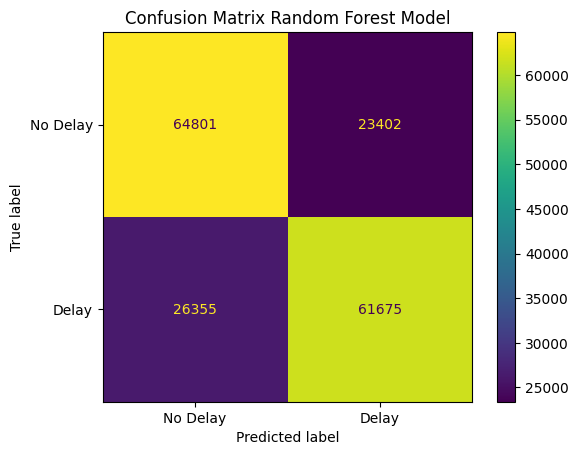

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Delay', 'Delay'])
disp.plot()
plt.title("Confusion Matrix Random Forest Model")
plt.show()

## Predik Acak
<p>Lima sampel acak dari data uji ditampilkan beserta hasil prediksi dan label sebenarnya. Hal ini memberikan gambaran konkret tentang performa model pada contoh nyata dan memperlihatkan bagaimana model membuat keputusan.<p>

In [15]:
label_map = {0: "No Delay", 1: "Delay"}

random_indices = random.sample(range(len(X_test)), 5)
print("\nContoh hasil klasifikasi (acak dari data test):")
for i, idx in enumerate(random_indices):
    actual = label_map[y_test.iloc[idx]]
    predicted = label_map[y_pred[idx]]
    print(f"Sample {i+1}: Actual = {actual}, Predicted = {predicted}")


Contoh hasil klasifikasi (acak dari data test):
Sample 1: Actual = Delay, Predicted = Delay
Sample 2: Actual = No Delay, Predicted = No Delay
Sample 3: Actual = No Delay, Predicted = No Delay
Sample 4: Actual = No Delay, Predicted = No Delay
Sample 5: Actual = No Delay, Predicted = No Delay
